In [4]:
import mdtraj as md
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

from scipy.spatial.distance import pdist, squareform
from tqdm import trange
import scipy.io as sio
import os, glob
from scipy.io import savemat

from tqdm import tqdm

In [5]:
hdir = '../../cdMD_trajectories/'
data_dirs = ['layer_7_1/',    # Single layer, 169 hexamers (8 rings)
             'layer_14/',     # Single layer, 531 hexamers (15 rings)
             'layer_7_2/',    # Double layer, inside-outside, 169 hexamers per layer (8 rings)
             'layer_7_2ii/',  # Double layer, inside-inside, 169 hexamers per layer (8 rings)
             'layer_7_2oo/'   # Double layer, outside-outside, 169 hexamers per layer (8 rings)
             ]

rep_dirs = ['1','2','3']

In [8]:
# Function to extract residue xyz coordinates from cgMD trajectory files
def getTraj(dir_num, rep_num):
    data_dir = data_dirs[dir_num]
    rep_dir = rep_dirs[rep_num]
    psf_files = glob.glob(os.path.join(hdir, data_dir, "*.psf"))
    topology_file = psf_files[0]
    xtc_files = glob.glob(os.path.join(hdir, data_dir, rep_dir, "*.xtc"))
    trajectory_file = xtc_files[0]

    print(f'Loading trajectory {data_dir}{rep_dir}')
    traj = md.load(trajectory_file, top=topology_file)
    coords = traj.xyz
    print('done')

    return coords

# Load list of neighbor pairs
def getNeighborPairs(dir_num):
    data_dir = data_dirs[dir_num]
    neighbor_file = glob.glob(os.path.join(hdir, data_dir, "*.csv"))
    neighborPairs = np.loadtxt(neighbor_file[0], delimiter=",")
    neighborPairs = neighborPairs.astype(int)
    neighborPairs -= 1 # Re-indexing. Matlab to Python
    
    return neighborPairs

In [10]:
# This function computes the orientation vector of a hexamer subunit
# by performing singular value decomposition (SVD) on the residue coordinates
def computeOrientation(atoms):
    points = np.asarray(atoms)
    
    # Define tail residue positions (residue 99 of each chain)
    tail_inds = np.linspace(1, 594 - 99 + 1, 6) + 98
    tail_inds = np.round(tail_inds).astype(int) - 1
    tail_points = points[tail_inds, :]
    
    # Fit plane to all points
    centroid = points.mean(axis=0)
    points_centered = points - centroid
    _, _, Vt = np.linalg.svd(points_centered, full_matrices=False)
    normal = Vt[-1, :]  # normal vector (unsigned)
    normal = normal / np.linalg.norm(normal)
    
    # Reference direction: vector from hexamer center to tail center
    tail_vector = tail_points.mean(axis=0) - centroid
    tail_vector /= np.linalg.norm(tail_vector)
    
    # Flip normal if pointing against tail_vector (ensure correct sign)
    if np.dot(normal, tail_vector) < 0:
        normal = -normal
    
    return normal

# Function to compute all subunit centroids and orientations at every frame
def computeCentroidsAndOrientations(coords):
    numHexamers = coords.shape[1] // (6*99)
    numFrames = coords.shape[0]

    centroids = np.zeros((numFrames, numHexamers, 3))
    normalVectors = np.zeros((numFrames, numHexamers, 3))
    for frame in tqdm(range(numFrames), desc="Computing centroids and normal vectors"):
        for h in range(numHexamers):
            atoms = np.arange(594) + 594*h
            atom_coords = coords[frame, atoms, :]
            centroids[frame, h, :] = atom_coords.mean(axis=0)
            normalVectors[frame, h, :] = computeOrientation(atom_coords)
    
    return centroids, normalVectors

# Function to compute the local curvatures
def computeLocalCurvature(centroids, normalVectors, neighborPairs):
    
    numFrames = normalVectors.shape[0]
    numHexamers = normalVectors.shape[1]
    
    localCurvature = np.zeros((numFrames, numHexamers), dtype=np.float32)
    
    for frame in tqdm(range(numFrames), desc="Computing local curvatures"):
        for h in range(numHexamers):
            
            # Find neighbors of hexamer h
            neighbor_indices = neighborPairs[np.where(neighborPairs[:, 0] == h)[0], 1]
            
            if len(neighbor_indices)==0: # No neighbors
                continue

            # Center-to-center distances
            center_diffs = centroids[frame, h, :] - centroids[frame, neighbor_indices, :]
            center_diff_norms = np.linalg.norm(center_diffs, axis=1)
            
            # Difference in orientations
            orientation_diffs = normalVectors[frame, h, :] - normalVectors[frame, neighbor_indices, :]
            diff_norms = np.linalg.norm(orientation_diffs, axis=1)
            
            localCurvature[frame, h] = np.mean(diff_norms / center_diff_norms) # average over neighbors
    
    return localCurvature

In [12]:
coordsAll = {}
normalVectorsAll = {}
localCurvaturesAll = {}

for dir_num in range(len(data_dirs)):

    # Load neighbor pair list
    neighborPairs = getNeighborPairs(dir_num)
    
    for rep_num in range(3):
        
        # Load trajectory coordinates
        coords = getTraj(dir_num, rep_num)

        # Compute subunit centroids and orientations
        centroids, normalVectors = computeCentroidsAndOrientations(coords)

        # Compute local curvature
        localCurvature = computeLocalCurvature(centroids, normalVectors, neighborPairs)

        # Store data
        coordsAll[(dir_num, rep_num)] = coords
        normalVectorsAll[(dir_num, rep_num)] = normalVectors
        localCurvaturesAll[(dir_num, rep_num)] = localCurvature

Loading trajectory layer_7_1/1
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 509.81it/s]


Loading trajectory layer_7_1/2
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 513.23it/s]


Loading trajectory layer_7_1/3
done


Computing local curvatures: 100%|███████████████████████████████████████████████████████████| 603/603 [00:01<00:00, 484.43it/s]


Loading trajectory layer_14/1
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.80it/s]


Loading trajectory layer_14/2
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.51it/s]


Loading trajectory layer_14/3
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.75it/s]


Loading trajectory layer_7_2/1
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.29it/s]


Loading trajectory layer_7_2/2
done


Computing local curvatures: 100%|███████████████████████████████████████████████████████████| 830/830 [00:03<00:00, 265.71it/s]


Loading trajectory layer_7_2/3
done


Computing local curvatures: 100%|███████████████████████████████████████████████████████████| 919/919 [00:03<00:00, 261.91it/s]


Loading trajectory layer_7_2ii/1
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.82it/s]


Loading trajectory layer_7_2ii/2
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.16it/s]


Loading trajectory layer_7_2ii/3
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.60it/s]


Loading trajectory layer_7_2oo/1
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.71it/s]


Loading trajectory layer_7_2oo/2
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.93it/s]


Loading trajectory layer_7_2oo/3
done


Computing local curvatures: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.45it/s]


In [ ]:
n = 256
cmap = np.zeros((n, 3))
cmap[:, 0] = np.linspace(0, 1, n)
cmap[:, 1] = 0
cmap[:, 2] = np.linspace(1, 0, n)
cmap_custom = ListedColormap(cmap)

maxcval = 0.06 #0.5 / 6.81
def curvature2colorindex(x):
    idx = np.round(1 + x * (255 / maxcval)).astype(int)
    return np.clip(idx, 1, n) - 1

for dir_num in range(len(data_dirs)):
    for rep_num in range(3):
        localCurvatures = localCurvaturesAll[(dir_num, rep_num)]
        coords = coordsAll[(dir_num, rep_num)]
        coords -= np.mean(coords, axis=1, keepdims=True) # Center of mass at origin
        
        frames_to_show = [0, 99, coords.shape[0]-1]
        
        fig = plt.figure(figsize=(18, 6))
        
        npoints_per_hexamer = 594
        nhexamers = localCurvatures.shape[1]

    
        for i, frame in enumerate(frames_to_show, 1):
            ax = fig.add_subplot(1, 3, i, projection="3d")
            
            for hexamer in range(nhexamers):
                inds = np.arange(npoints_per_hexamer) + npoints_per_hexamer * hexamer
                points = coords[frame, inds, :]  # (594, 3)
        
                # One curvature value per hexamer = one color for whole hexamer
                cval = float(localCurvatures[frame, hexamer])
                color = cmap[curvature2colorindex(cval)]
        
                ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                           s=0.01, color=color, alpha=0.2)
        
            ax.set_title(f"Frame {frame+1}")
            ax.set_xlabel("x (nm)")
            ax.set_ylabel("y (nm)")
            ax.set_zlabel("z (nm)", rotation=90, labelpad=-227)
            ax.zaxis.set_ticks_position('lower')
            ax.set_box_aspect([1, 1, 1])
            
            lim = 70
            ax.set_xlim([-lim, lim])
            ax.set_ylim([-lim, lim])
            ax.set_zlim([-lim, lim])
        
            norm = mpl.colors.Normalize(vmin=0, vmax=maxcval)
            sm = plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=-0.03)
            cbar.set_label(r"Local Curvature (nm$^{-1}$)")
            
            ticks = cbar.get_ticks()
            ticklabels = [f"{t:.02f}" for t in ticks]
            if ticklabels:
                ticklabels[-1] = f"≥{maxcval}"
            cbar.set_ticks(ticks)
            cbar.set_ticklabels(ticklabels)
        
        plt.tight_layout()
        plt.show()

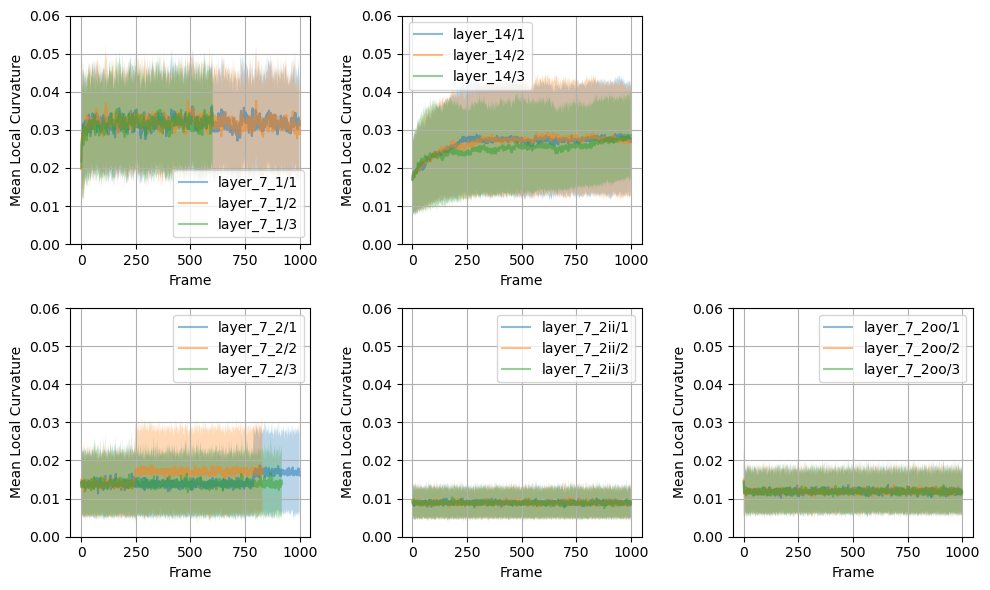

In [14]:
plt.figure(figsize=(10, 6))

subplots = [1, 2, 4, 5, 6]
for dir_num in range(len(data_dirs)):
    
    plt.subplot(2,3, subplots[dir_num])    
    
    for rep_num in range(3):
        meanCurvature = np.nanmean(localCurvaturesAll[(dir_num, rep_num)], axis=1)
        stdCurvature = np.nanstd(localCurvaturesAll[(dir_num, rep_num)], axis=1)
        frames = np.arange(meanCurvature.shape[0])
        
        # Plot mean curve
        plt.plot(frames, meanCurvature, label=f"{data_dirs[dir_num]}{rep_num+1}",color='C'+str(rep_num),alpha=0.5)
        
        # Plot shaded error region
        lower = meanCurvature - stdCurvature
        upper = meanCurvature + stdCurvature
        plt.fill_between(frames, lower, upper, color='C'+str(rep_num), alpha=0.3, edgecolor='none')
    
    plt.xlabel("Frame")
    plt.ylabel("Mean Local Curvature")
    plt.legend()
    plt.tight_layout()
    plt.ylim(0,0.06)
    plt.grid()

plt.show()